In [1]:
import matplotlib.pyplot as plt
import sys
import random
import numpy as np
from tqdm import tqdm

pb_convert = 3.894E8 # conversion factor GeV^-2 -> pb
MZ = 91.188    # Z boson mass
GAMMAZ = 2.4414 # Z boson width
alpha = 1/132.507 # alpha QED
Gfermi = 1.16639E-5 # fermi constant
sw2 = 0.222246 # sin^2(weinberg angle)

# e+e- COM energy in GeV
ECM = 90
hats = ECM ** 2

print('ECM', ECM, 'GeV')

## first we define a function that gives the differential cross section
## as a function of the parameters
## we include anything that depends on s, even though in this case they are fixed for future use with variable s (hadron collisions)
def dsigma(costh):
    return ((np.pi * 2 * alpha ** 2) / (4 * hats)) * (1 + costh ** 2)

## in the first step, we aim to calculate:
## - the cross section
## - and the maximum point of the phase space

# set the seed for random numbers 
# random.random() will give us random numbers using the Mersenne Twister algorithm
# see: https://docs.python.org/2/library/random.html
seed = 12342
random.seed(seed)

# the loop for the integration should start here
# N is the number of points we wish to integrate over
N = 10 ** 6
sum_w = 0
sum_w_sq = 0
w_max = 0
costh_max = -2
for ii in tqdm(range(0 , N)): 
    # We need to generate a random cos(theta)
    # this corresponds to a phase-space point 
    # then we calculate the "weight" for that
    # point and increment it to the sum of weights.
    # Since we also want to calculate the error,
    # we must also calculate the sum of the squares
    # of the weights
    
    costh_ii = -1 + random.random() * 2

    # calc. phase space point weight
    w_ii = dsigma(costh_ii) * 2

    # add to the sums
    sum_w = sum_w + w_ii
    sum_w_sq = sum_w_sq + w_ii ** 2
    
    # for event generation:
    # check if this point is the maximum
    # and store it if so.
    if w_ii > w_max :
        w_max = w_ii
        costh_max = costh_ii

# calculate cross section
sigma = sum_w / N
analytic = (4 * np.pi * alpha ** 2) / (3 * hats)

# and its error through the variance
variance = (1 / N) * sum_w_sq - (sigma) ** 2
error = np.sqrt(variance / N)

# don't forget to convert the GeV^-2 to pb! 
print('maximum value of dsigma = '+str(w_max)+' at cos(theta) '+str(costh_max)+'')
print('cross-section = '+str(sigma * pb_convert)+' +/ '+str(error * pb_convert)+' pb')
print('analytical cross-section = '+str(analytic * pb_convert)+' pb')

# here we can also compare to the analytical values 

## now that we have the maximum, we can generate "events"
## in this simple case, we only have one parameter, costh
## we can translate this parameter into momenta for the outgoing particles

# we will store "generated" costh in an array:
costh_P = []

rap_P = []

ptrans_P = []
# required Number of events to generate
Neve = 10 ** 3
# a counter of events generated in the loop
jj = 0
# start generating events (i.e. "hit or miss") 
# jj counts the events, so stay in this loop until we have generated the required number
while jj < Neve:
    sys.stdout.write("progress: %d%%   \r" % (float(jj)*100./(Neve)) )
    sys.stdout.flush()
    costh_ii = -1 + random.random() * 2
    w_ii = dsigma(costh_ii) * 2

    # Divide the weight by the maximum weight stored in the integration step
    # this will create a "probability for the event.
    prob = w_ii / w_max
    rand_num = random.random()

    # compare to a random number
    # and accept or reject the event
    # according to the hit-or-miss algorithm
    # if the random number is less than the probability of the PS point
    # accept
    if rand_num < prob:
        costh_P += [costh_ii]
        jj = jj + 1
        # the process is phi-symm, so random phi is appropriate
        phi = random.random() * 2 * np.pi
        cosphi = np.cos(phi)
        sinphi = np.sin(phi)
        sinth = np.sqrt(1 - costh_ii ** 2)
        pem = [ 0.5 * ECM, 0., 0., 0.5 * ECM ]
        pep = [ 0.5 * ECM, 0., 0., - 0.5 * ECM ]
        pmm = [ 0.5 * ECM, 0.5 * ECM * sinth * cosphi, 0.5 * ECM * sinth * sinphi, 0.5 * ECM * costh_ii ]
        #pmml = [ 0.5 * ECM, -0.5 * ECM * sinth * cosphi, -0.5 * ECM * sinth * sinphi, -0.5 * ECM * costh_ii ] #lower index
        pmp = [ 0.5 * ECM, - 0.5 * ECM * sinth * cosphi, - 0.5 * ECM * sinth * sinphi, - 0.5 * ECM * costh_ii ]
        #pmpl = [ 0.5 * ECM, 0.5 * ECM * sinth * cosphi, 0.5 * ECM * sinth * sinphi, 0.5 * ECM * costh_ii ] #lower index
        theta = np.arccos(costh_ii)
        psuerap = -np.log(np.tan(0.5 * theta))
        rap_P += [psuerap]
        ptrans = np.sqrt(pmm[1] ** 2 + pmm[2] ** 2)
        ptrans_P += [ptrans]


ECM 90 GeV


100%|████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:03<00:00, 321238.37it/s]

maximum value of dsigma = 4.417911219479412e-08 at cos(theta) -0.9999994883503418
cross-section = 11.467492121480879 +/ 0.0025641685565077938 pb
analytical cross-section = 11.468903393827555 pb


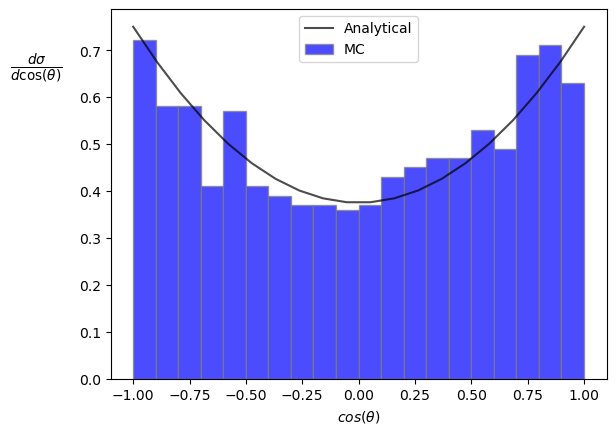

In [10]:
def func(n, x):
    return n * (1 / analytic) * (1 + x ** 2)
fig, ax = plt.subplots()
ps = np.linspace(-1, 1, 20)
y = func((np.pi * alpha ** 2) / (2 * hats), ps) 
ax.plot(ps, y, color = 'black', alpha = 0.7, label = 'Analytical')
ax.hist(x = costh_P, bins = 20, color = 'blue', density = 'True', alpha = 0.7, edgecolor = 'gray', label = 'MC')
plt.xlabel(r'$cos(\theta)$')
plt.ylabel(r'$\frac{d\sigma}{d\cos(\theta)}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.legend()
plt.show()

In [5]:
plt.hist(x = costh_P, bins = 20)

(array([72., 58., 58., 41., 57., 41., 39., 37., 37., 36., 37., 43., 45.,
        47., 47., 53., 49., 69., 71., 63.]),
 array([-9.99696824e-01, -8.99790742e-01, -7.99884661e-01, -6.99978579e-01,
        -6.00072498e-01, -5.00166416e-01, -4.00260335e-01, -3.00354253e-01,
        -2.00448171e-01, -1.00542090e-01, -6.36008343e-04,  9.92700732e-02,
         1.99176155e-01,  2.99082236e-01,  3.98988318e-01,  4.98894399e-01,
         5.98800481e-01,  6.98706563e-01,  7.98612644e-01,  8.98518726e-01,
         9.98424807e-01]),
 <BarContainer object of 20 artists>)

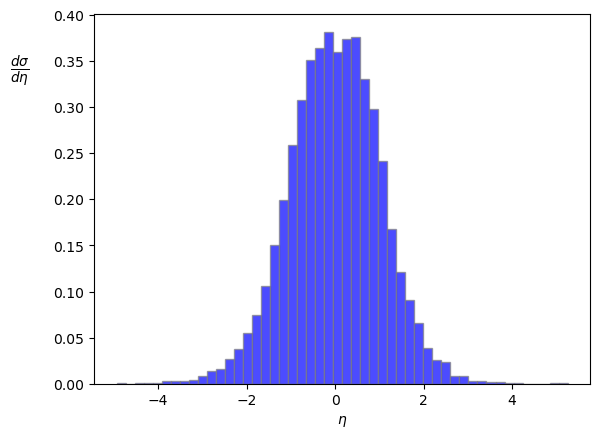

In [40]:
fig, ax = plt.subplots()
plt.hist(x = rap_P, bins = 50, density = 'True', color = 'blue', alpha = 0.7, edgecolor = 'gray', label = 'MC')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\frac{d\sigma}{d\eta}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.show()
# analytical function is non-trivial

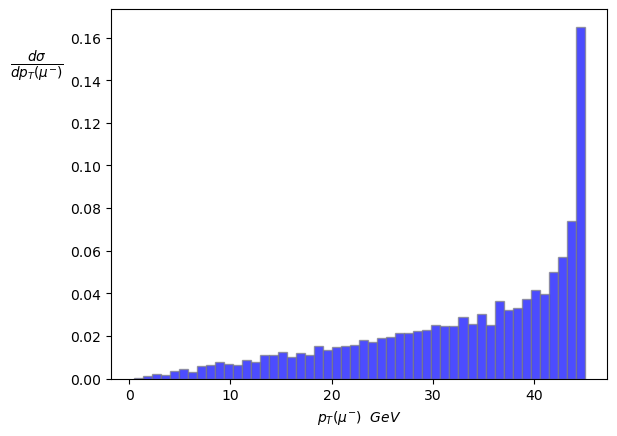

In [43]:
fig, ax = plt.subplots()
plt.hist(x = ptrans_P, bins = 50, density = 'True', color = 'blue', edgecolor = 'gray', alpha = 0.7, label = 'MC')
plt.xlabel(r'$p_T(\mu^{-})$  $GeV$')
plt.ylabel(r'$\frac{d\sigma}{dp_T(\mu^{-})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.show()
# analytical function non trivial

In [44]:
costh_pos = []
costh_neg = []
for i in costh_P:
    if i > 0:
        costh_pos += [i]
    else:
        costh_neg += [i]

In [45]:
w_pos = 2 * dsigma(np.array(costh_pos))
w_neg = 2 * dsigma(np.array(costh_neg))
sigma_pos = (np.sum(w_pos) / len(w_pos)) * pb_convert
sigma_neg = (np.sum(w_neg) / len(w_neg)) * pb_convert
assym = (sigma_pos - sigma_neg) / (sigma_pos + sigma_neg)

In [46]:
print(assym) #should be no assymmetry since the QED interaction does not violate parity

-0.00025710858318973325
